# 01 – EDA: Trip Duration Prediction




نعمل امبورت للمكتبات اللي هنستخدمها 

In [13]:
import sys
import os

# خلي Python يشوف مجلد src
sys.path.append(os.path.abspath(os.path.join("..", "src")))

# دلوقتي تقدر تستدعي الموديولز
from features.distances import add_distance_features
from features.timeparts import add_time_features
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# أول نظرة سريعة
Initial Load & Overview

In [14]:
df = pd.read_csv(r"G:\ML mostafa saad\slides\my work\13 Project 1 - Regression - Trip Duration Prediction\data\raw\train.csv")

print(df.shape)
print(df.head())
print(df.info())







KeyboardInterrupt: 

عايز افهم كل عمود شويه واطلع لو فيه ممكن شوية مشاكل وازاي اقدر اتعامل معاها 


2️⃣ Missing Values Check

df.isnull().sum()

حدد أي عمود فيه قيم ناقصة

هدف: نقرر هل نعوض Missing Values أو نحذفها.

In [ ]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

3️⃣ Target Variable Analysis
هجوله الاول لدقايق لسهوله الفهم

trip_duration → histogram / kde

حساب skew و outliers

فكّر إذا نحتاج log-transform

هدف: نفهم توزيع الهدف قبل أي مودلينج.

   trip_duration  trip_duration_min
0            455           7.583333
1            663          11.050000
2           2124          35.400000
3            429           7.150000
4            435           7.250000


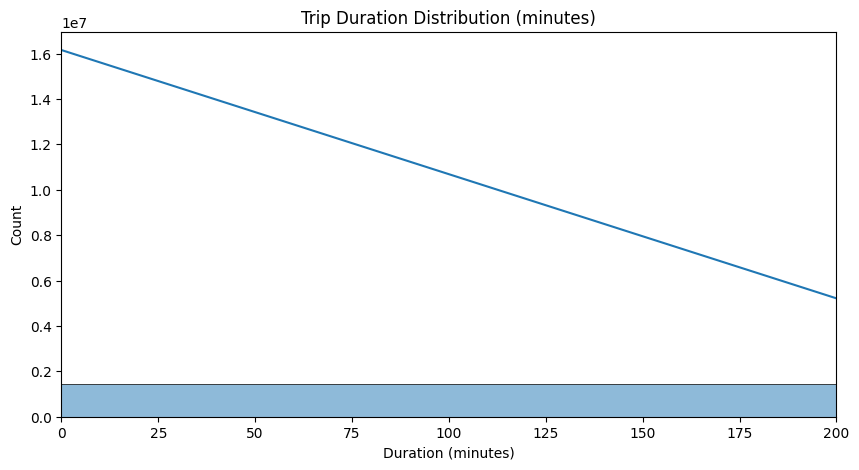

Skewness of trip_duration (minutes): 343.16
Trips with duration < 1 min: 8595
Trips with duration > 120 min: 2253


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# تحويل من ثواني لدقايق
df['trip_duration_min'] = df['trip_duration'] / 60

# لمعاينة التوزيع
print(df[['trip_duration', 'trip_duration_min']].head())


plt.figure(figsize=(10,5))
sns.histplot(df['trip_duration_min'], bins=100, kde=True)
plt.xlim(0, 200)  # نفترض أن أغلب الرحلات أقل من 200 دقيقة
plt.title("Trip Duration Distribution (minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.show()

# حساب skew
skewness = df['trip_duration_min'].skew()
print(f"Skewness of trip_duration (minutes): {skewness:.2f}")

# اكتشاف الرحلات القصيرة والطويلة
print("Trips with duration < 1 min:", (df['trip_duration_min'] < 1).sum())
print("Trips with duration > 120 min:", (df['trip_duration_min'] > 120).sum())


هنا طبعا لقينا انحراف كبير 

معظم الرحلات مدتها قصيرة (أقل من 1000 ثانية تقريبًا)، ويوجد عدد قليل من الرحلات الطويلة جدًا.
التوزيع منحرف (skewed) ناحية اليمين، أي أن هناك رحلات قليلة جدًا مدتها طويلة جدًا (outliers).
يوجد عدد كبير من الرحلات أقل من دقيقة، وعدد قليل جدًا فوق ساعتين.

فغالبا هنعمل(log-transform)   

4️⃣ Categorical Columns Analysis vendor_id, store_and_fwd_flag → value_counts معرفة التوزيع لكل category تقرير إذا نعمل one-hot encoding أو label encoding
print(df['store_and_fwd_flag'].value_counts())


In [ ]:
# vendor_id
print("vendor_id value counts:")
print(df['vendor_id'].value_counts())

# store_and_fwd_flag
print("\nstore_and_fwd_flag value counts:")
print(df['store_and_fwd_flag'].value_counts())


vendor_id value counts:
vendor_id
2    780302
1    678342
Name: count, dtype: int64

store_and_fwd_flag value counts:
store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64


هدفنا:

التأكد أن الرحلات داخل نيويورك

اكتشاف أي إحداثيات غريبة

       pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude
count     1.458644e+06      1.458644e+06      1.458644e+06       1.458644e+06
mean      4.075092e+01     -7.397349e+01      4.075180e+01      -7.397342e+01
std       3.288119e-02      7.090186e-02      3.589056e-02       7.064327e-02
min       3.435970e+01     -1.219333e+02      3.218114e+01      -1.219333e+02
25%       4.073735e+01     -7.399187e+01      4.073588e+01      -7.399133e+01
50%       4.075410e+01     -7.398174e+01      4.075452e+01      -7.397975e+01
75%       4.076836e+01     -7.396733e+01      4.076981e+01      -7.396301e+01
max       5.188108e+01     -6.133553e+01      4.392103e+01      -6.133553e+01


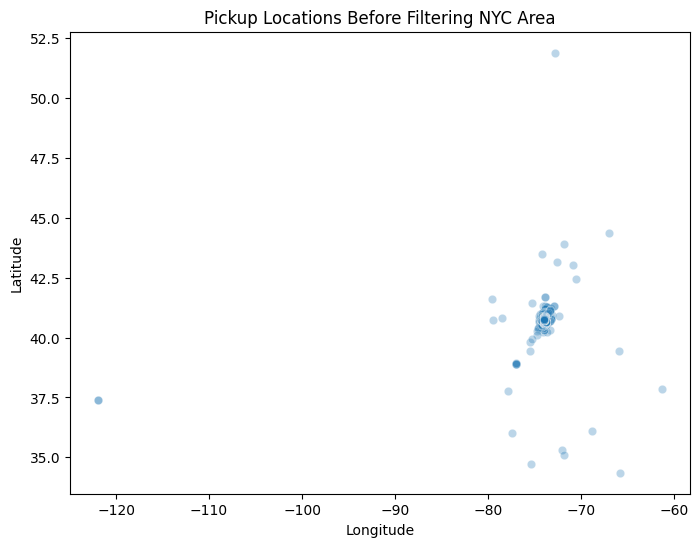

عدد الرحلات خارج النطاق تماماً: 4890 من أصل 1458644 رحلة
عدد الرحلات بعد الحذف: 1453754


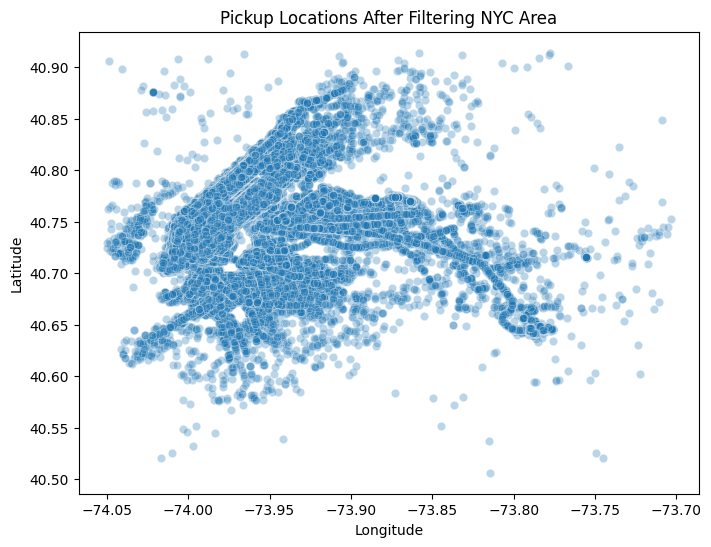

In [ ]:
# وصف إحصائي للإحداثيات
print(df[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']].describe())

# رسم توزيع نقاط الانطلاق قبل الحذف
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=df, alpha=0.3)
plt.title("Pickup Locations Before Filtering NYC Area")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# تحديد نطاق نيويورك (threshold معقول)
lat_min, lat_max = 40.5, 40.92
lon_min, lon_max = -74.05, -73.7

mask_nyc = (
    (df['pickup_latitude'].between(lat_min, lat_max)) &
    (df['pickup_longitude'].between(lon_min, lon_max)) &
    (df['dropoff_latitude'].between(lat_min, lat_max)) &
    (df['dropoff_longitude'].between(lon_min, lon_max))
)

# عدد الرحلات خارج النطاق
num_outside = (~mask_nyc).sum()
print(f"عدد الرحلات خارج النطاق تماماً: {num_outside} من أصل {len(df)} رحلة")

# حذف الرحلات خارج النطاق
df = df[mask_nyc].copy()
print(f"عدد الرحلات بعد الحذف: {len(df)}")

# رسم توزيع نقاط الانطلاق بعد الحذف
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=df, alpha=0.3)
plt.title("Pickup Locations After Filtering NYC Area")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

لاحظنا ان في رحلات كتير خارج نطاق نيويورك فهنعمل 

  اعمي threeshold ?فوق وتحت يكون معقول عشان نبقا نحذف الباقي وقولي عدد الرحلات اللي خارج النطاق خالص

هدفنا:

نفهم الزحمة حسب الساعة أو يوم الأسبوع

نقرر feature engineering لاحقًا (rush_hour, weekday, month…)

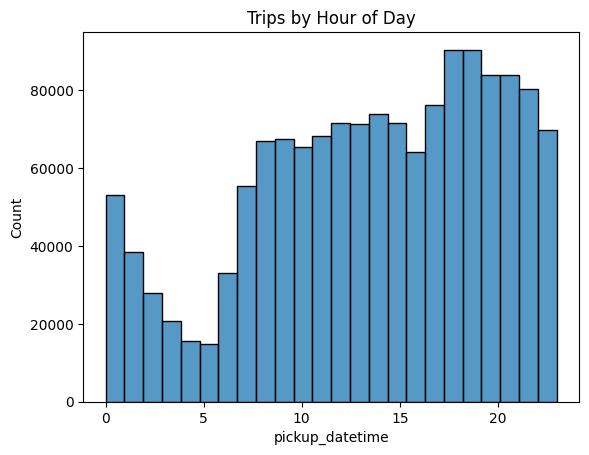

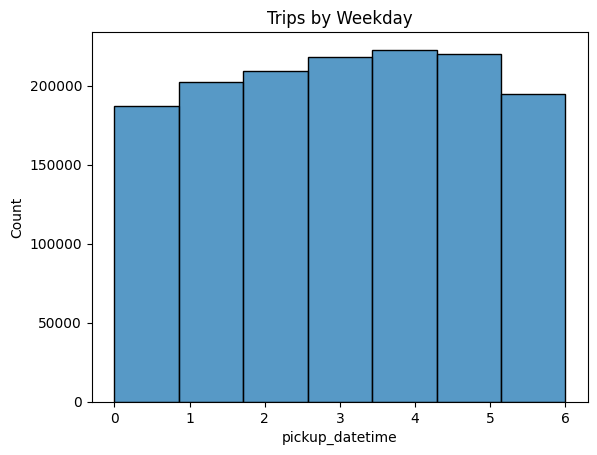

In [ ]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
sns.histplot(df['pickup_datetime'].dt.hour, bins=24)
plt.title("Trips by Hour of Day")
plt.show()

sns.histplot(df['pickup_datetime'].dt.weekday, bins=7)
plt.title("Trips by Weekday")
plt.show()


From the "Trips by Hour of Day" histogram, the most rush hours appear to be between 17:00 and 21:00 (5 PM to 9 PM), where the trip counts are highest. This likely corresponds to evening commute times. There is also a moderate peak around 8:00 to 10:00 (morning rush).

دلوقتي عايزين نعرف العلاقات بين الاعمده او الفيشتر اللي عندنا مع التارجت فاليو بتاعتنا 
1️⃣ Correlation بين الأعمدة العددية والـ trip_duration

trip_duration_min    1.000000
trip_duration        1.000000
pickup_longitude     0.049168
dropoff_longitude    0.033527
vendor_id            0.020177
passenger_count      0.008392
dropoff_latitude    -0.023109
pickup_latitude     -0.033785
Name: trip_duration_min, dtype: float64


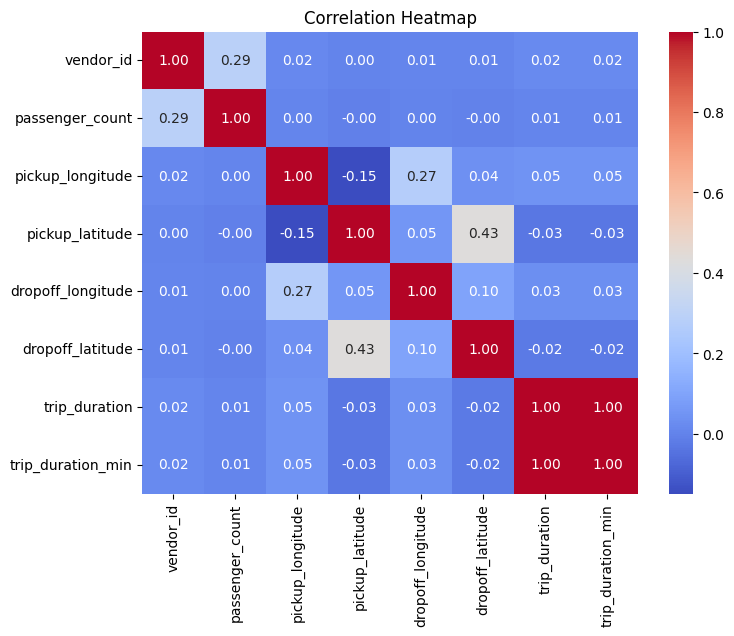

In [ ]:
# ناخد الأعمدة العددية فقط
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# correlation matrix
corr = df[numeric_cols].corr()

# نشوف علاقة trip_duration_min مع باقي الأرقام
print(corr['trip_duration_min'].sort_values(ascending=False))

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


طبعا لقينا ان العلاقات مش مباشره اوي لان لسه لداتاا مش معبره اوي 

فمحتاجين نطلع features  جديده تكون معبره وليها علاقه بالدومين اكتر

نحاول نشوف علاقة عدد الركاب بطول الرحله لان عندي شك ان ممكن عدد الركاب الكبير يطول الرحله اكتر

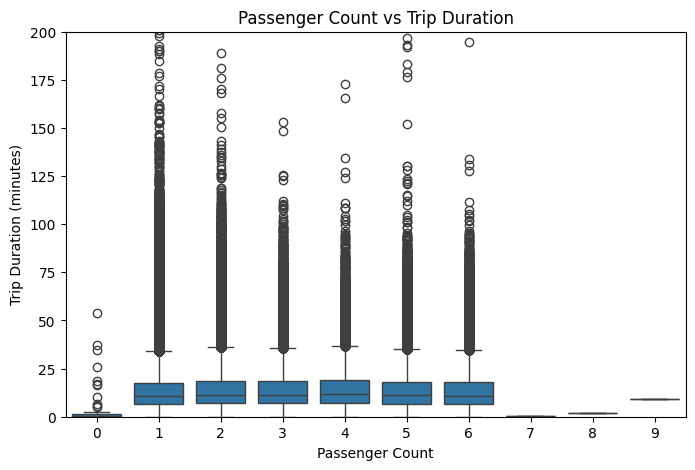

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='passenger_count', y='trip_duration_min')
plt.ylim(0, 200)  # عشان القيم المتطرفة ما تبانش بشكل مبالغ فيه
plt.title("Passenger Count vs Trip Duration")
plt.xlabel("Passenger Count")
plt.ylabel("Trip Duration (minutes)")
plt.show()


نستنتج من هنا ان عدد الركاب مش بيأثر فعليا علي طول الرحله 

نبص بصه علي Vendor & Store_and_fwd_flag vs trip_duration

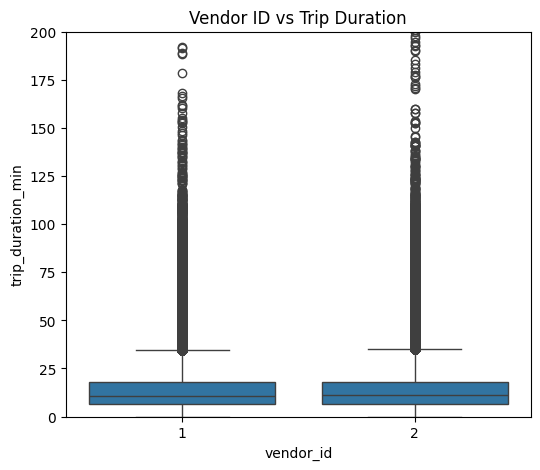

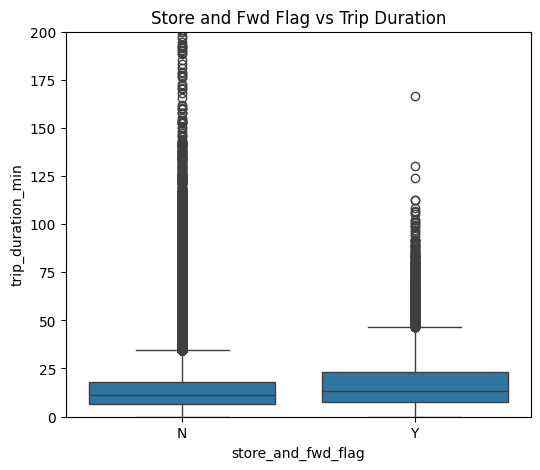

In [ ]:
# Vendor
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x='vendor_id', y='trip_duration_min')
plt.ylim(0, 200)
plt.title("Vendor ID vs Trip Duration")
plt.show()

# Store and Forward
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x='store_and_fwd_flag', y='trip_duration_min')
plt.ylim(0, 200)
plt.title("Store and Fwd Flag vs Trip Duration")
plt.show()


 ملهوش علاقه يعتبر  Vendor نستنتح ان  ال 
 
 يعتبر اه بيأثر شويه يعني الرحلات اللي كان في مشكله فالكونيكشن وعملت تخزين الاول وبعدين بعتت التفاصيل متوسط رحالتها مدتها اكبر من اللي بعت الداتا علطول  Store_and_fwd_flag   ولكن فلاج ال 

دلوقتي خدنا فكره عامه عن الداتا بتاعتنا لقيناها مش معبره كفايه ولكن منها نقدر ننشأ features جديده تكون معبره اكتر وليها علاقه مباشره بالتارجت بتاعنا 
زي ايه بقا نجيب بعض المسافات من معلومات خطوط االطول ودواير العرض بتاع مكان الاقلاع ومكان الانتهاء 
Distances: Haversine, Manhattan
Directions: Bearing ,speed_kmh
وبرضو عمود الداتاتايم لو فصلناه يبقا افضل لان الساعه ممكن تكون اهم من التاريخ وهل اليوم ده كان ويك اند ولا عادي فبرضو هنعمل شغل علي اعمدة الداتا تايم 
كل ده هنستخدم ملف  ال features لان كل الدوال منظمه جواه

 02_feature_engineeringنروح بقا لنوتبوك ال 

ونحفظ الملف 


دلوقتي بعد ما ضيفنا الفيتشرز الجديده وشوفناا شويه منهم فعلا نقدر نقول انها منطقيه اكتر وليها معني 
المسافات الاكبر بتعمل وقت اعلي ولو مسافتين متساويتين السرعه الاعلي تعمل مده اقل 

دلوقتي بقا نبدأ نبص بصه ونشوف العلاقات بقا بين الفيتشرز الجديده والتارجت
بعد ما عملنا انشاء فيتشرز وهوت انكودنج علي كاتيجوري فيتشر زمسحنا تقريبا 13% من الاوتلايرز

In [29]:
path = "G:/ML mostafa saad/slides/my work/13 Project 1 - Regression - Trip Duration Prediction/data/processed/train_processed.csv"
df_processed = pd.read_csv(path)

df_processed.head()
print(df_processed.shape)
print(df_processed.info())
df_processed.describe()



(1274142, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274142 entries, 0 to 1274141
Data columns (total 34 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     1274142 non-null  object 
 1   pickup_datetime        1274142 non-null  object 
 2   dropoff_datetime       1274142 non-null  object 
 3   passenger_count        1274142 non-null  int64  
 4   pickup_longitude       1274142 non-null  float64
 5   pickup_latitude        1274142 non-null  float64
 6   dropoff_longitude      1274142 non-null  float64
 7   dropoff_latitude       1274142 non-null  float64
 8   trip_duration_min      1274142 non-null  float64
 9   haversine_km           1274142 non-null  float64
 10  manhattan_km           1274142 non-null  float64
 11  bearing_deg            1274142 non-null  float64
 12  speed_kmh              1274142 non-null  float64
 13  hour                   1274142 non-null  int64  
 14  is_w

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration_min,haversine_km,manhattan_km,bearing_deg,speed_kmh,hour,is_weekend,is_rush_hour,log_trip_duration_min
count,1.274142e+06,1.274142e+06,1.274142e+06,1.274142e+06,1.274142e+06,1.274142e+06,1.274142e+06,1.274142e+06,1.274142e+06,1.274142e+06,1.274142e+06,1.274142e+06,1.274142e+06,1.274142e+06
mean,1.660824e+00,-7.397970e+01,4.075289e+01,-7.397803e+01,4.075285e+01,1.153257e+01,2.294081e+00,2.944654e+00,-1.641785e+01,1.277192e+01,1.372009e+01,2.844981e-01,4.402500e-01,2.369969e+00
std,1.312443e+00,6.686709e-02,2.653352e-02,6.726901e-02,2.861175e-02,7.006151e+00,1.545452e+00,1.987255e+00,1.053279e+02,5.680967e+00,6.292898e+00,4.511752e-01,4.964173e-01,5.830919e-01
min,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.435970e+01,1.666667e-02,0.000000e+00,0.000000e+00,-1.799918e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.652930e-02
25%,1.000000e+00,-7.399219e+01,4.073867e+01,-7.399169e+01,4.073799e+01,6.250000e+00,1.152391e+00,1.465127e+00,-1.300189e+02,8.724849e+00,9.000000e+00,0.000000e+00,0.000000e+00,1.981001e+00
50%,1.000000e+00,-7.398223e+01,4.075422e+01,-7.398093e+01,4.075460e+01,1.005000e+01,1.863801e+00,2.390178e+00,7.603510e+00,1.198077e+01,1.400000e+01,0.000000e+00,0.000000e+00,2.402430e+00
75%,2.000000e+00,-7.396983e+01,4.076767e+01,-7.396711e+01,4.076873e+01,1.530000e+01,3.039295e+00,3.915585e+00,5.224830e+01,1.607451e+01,1.900000e+01,1.000000e+00,1.000000e+00,2.791165e+00
max,9.000000e+00,-6.133553e+01,4.391176e+01,-6.133553e+01,4.391176e+01,4.051667e+01,8.427831e+00,9.295454e+00,1.800000e+02,3.144230e+01,2.300000e+01,1.000000e+00,1.000000e+00,3.726095e+00


نبدا بقا نشوف العلاقات دلوقتي بين الفيتشرز الجديده والتارجت


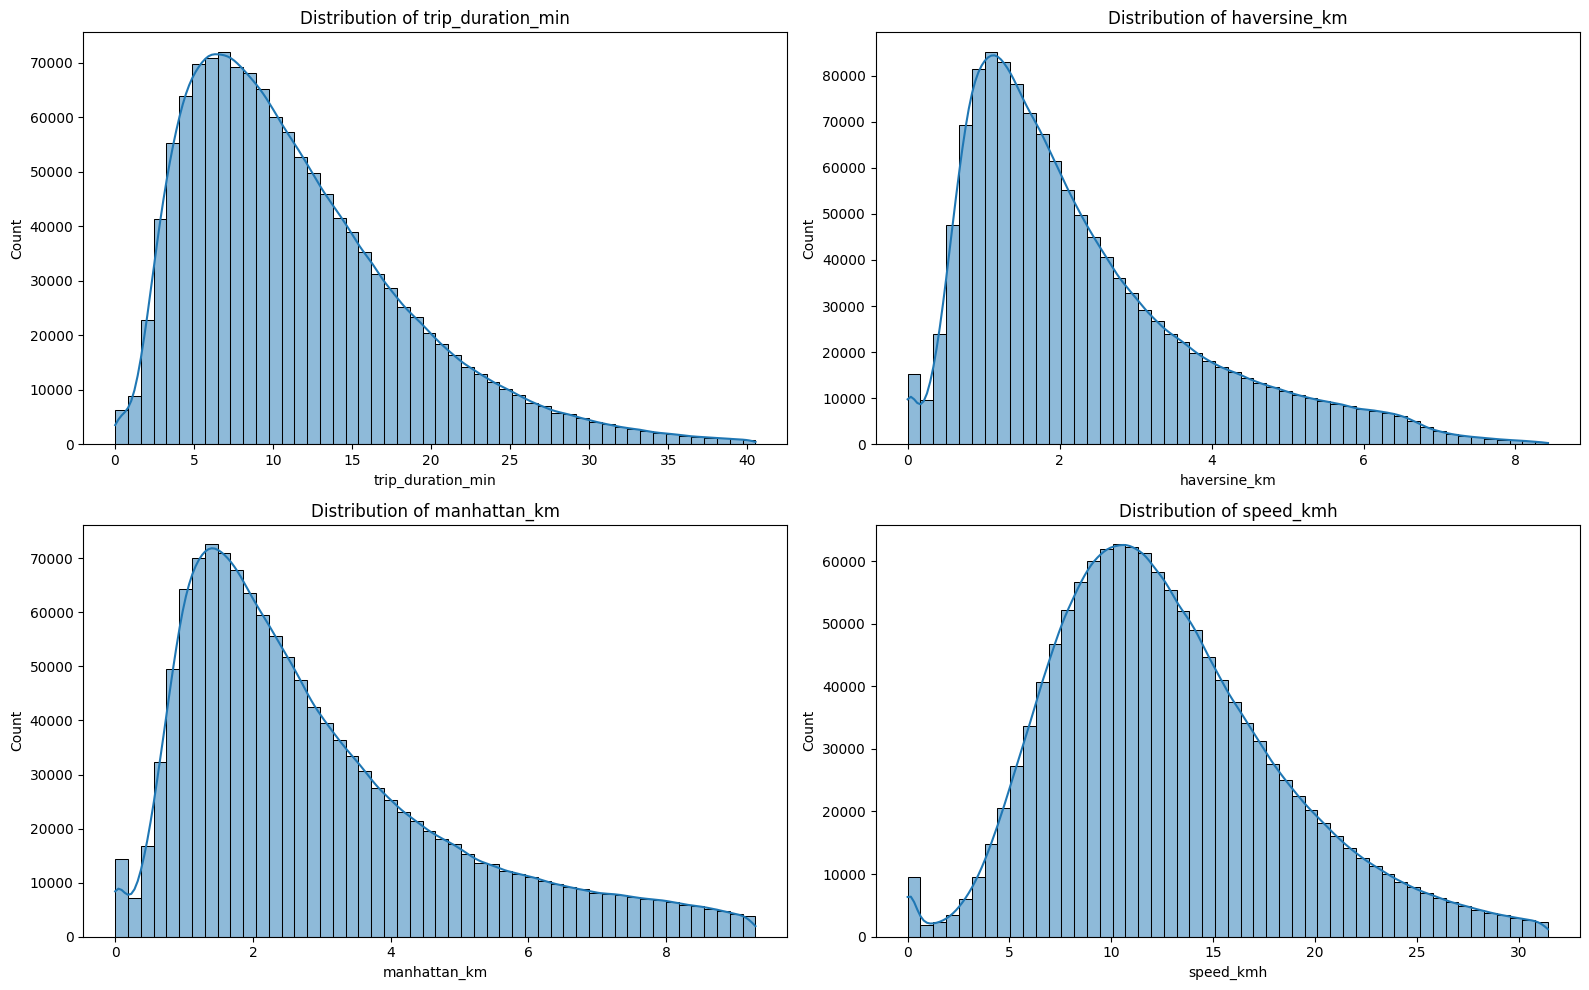

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['trip_duration_min', 'haversine_km', 'manhattan_km', 'speed_kmh']

plt.figure(figsize=(16,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_processed[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [31]:
print(df_processed[df_processed['speed_kmh'] < 5][['trip_duration_min', 'haversine_km', 'speed_kmh']].head(10))

# عرض بعض الرحلات السريعة جداً
print(df_processed[df_processed['speed_kmh'] > 30][['trip_duration_min', 'haversine_km', 'speed_kmh']].head(10))

# وصف إحصائي للسرعة
print(df_processed['speed_kmh'].describe())

     trip_duration_min  haversine_km  speed_kmh
49           20.466667      1.560727   4.575423
76           19.566667      1.500309   4.600606
91           16.033333      1.191861   4.460187
98           16.200000      1.059709   3.924850
108           6.933333      0.375058   3.245692
113          15.566667      1.061889   4.092935
123          12.266667      0.729399   3.567710
139          14.483333      0.937779   3.884932
203          22.466667      1.246254   3.328275
206           3.783333      0.000000   0.000000
      trip_duration_min  haversine_km  speed_kmh
51             7.866667      4.021000  30.668641
103            1.683333      0.841746  30.002837
420            9.000000      4.511137  30.074246
436           11.150000      5.802127  31.222210
652            2.983333      1.556491  31.303735
812            1.416667      0.720592  30.519211
1421           2.316667      1.196748  30.994912
1495           5.983333      3.111173  31.198391
1584           1.700000      0.

كده نمام يعتبر منطقي واتوزيع بتاع الداتا سليم نسبيا

ودي نظره سريعه علي بعض 2 توزيع المتغيرات الفئوية

مثلاً:

passenger_count

hour, is_weekend, is_rush_hour

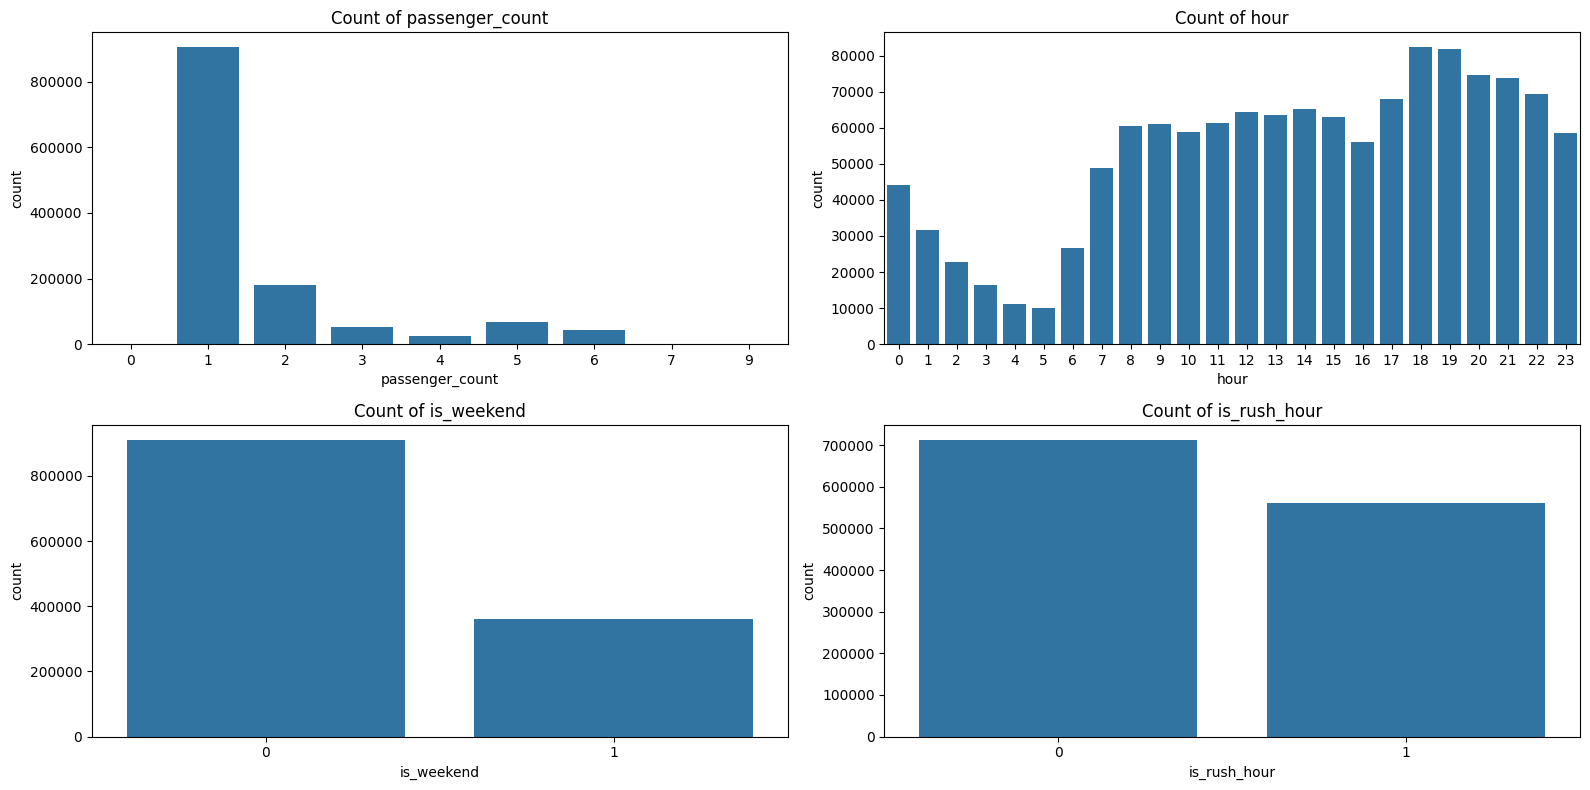

In [33]:
cat_cols = ['passenger_count', 'hour', 'is_weekend', 'is_rush_hour']

plt.figure(figsize=(16,8))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df_processed)
    plt.title(f'Count of {col}')
plt.tight_layout()
plt.show()


نشوف بقا بعض العلاقات بين  المتغيرات

مثلاً:

مدة الرحلة vs المسافة vs السرعة

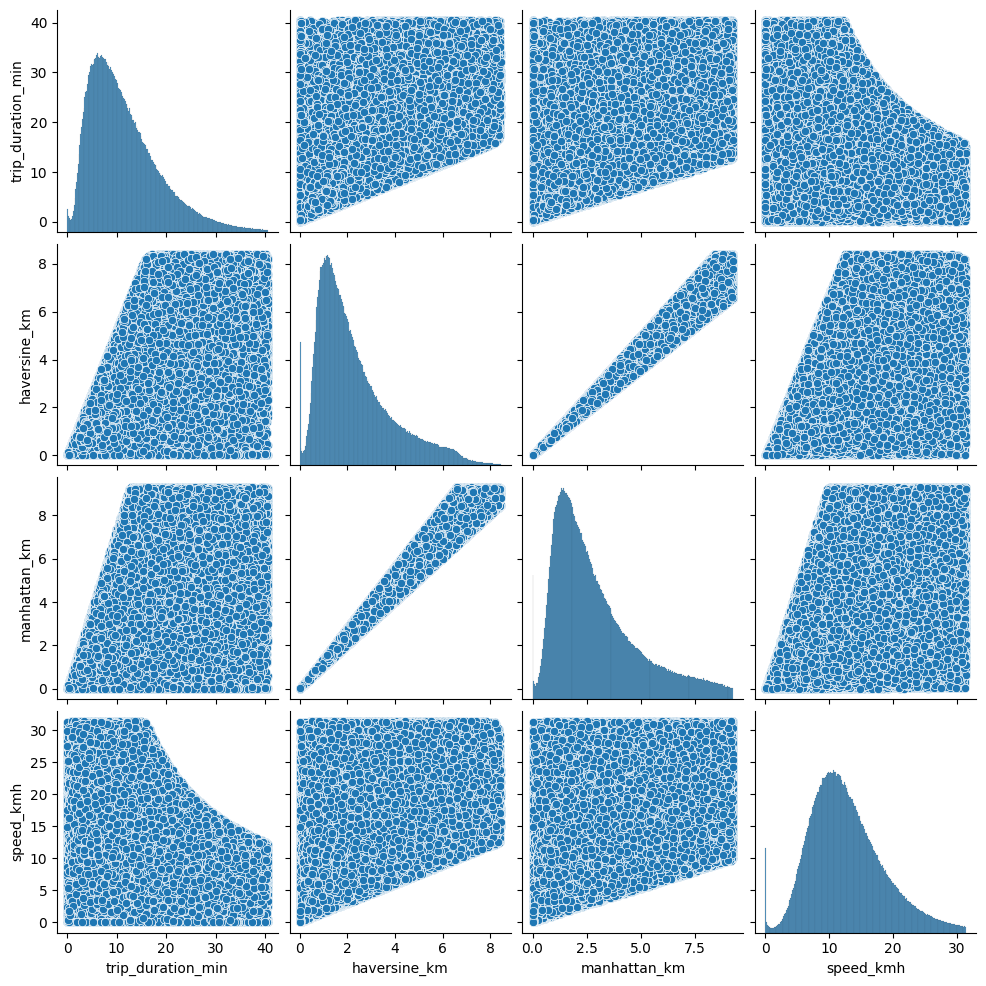

In [34]:
sns.pairplot(df_processed[['trip_duration_min', 'haversine_km', 'manhattan_km', 'speed_kmh']])
plt.show()


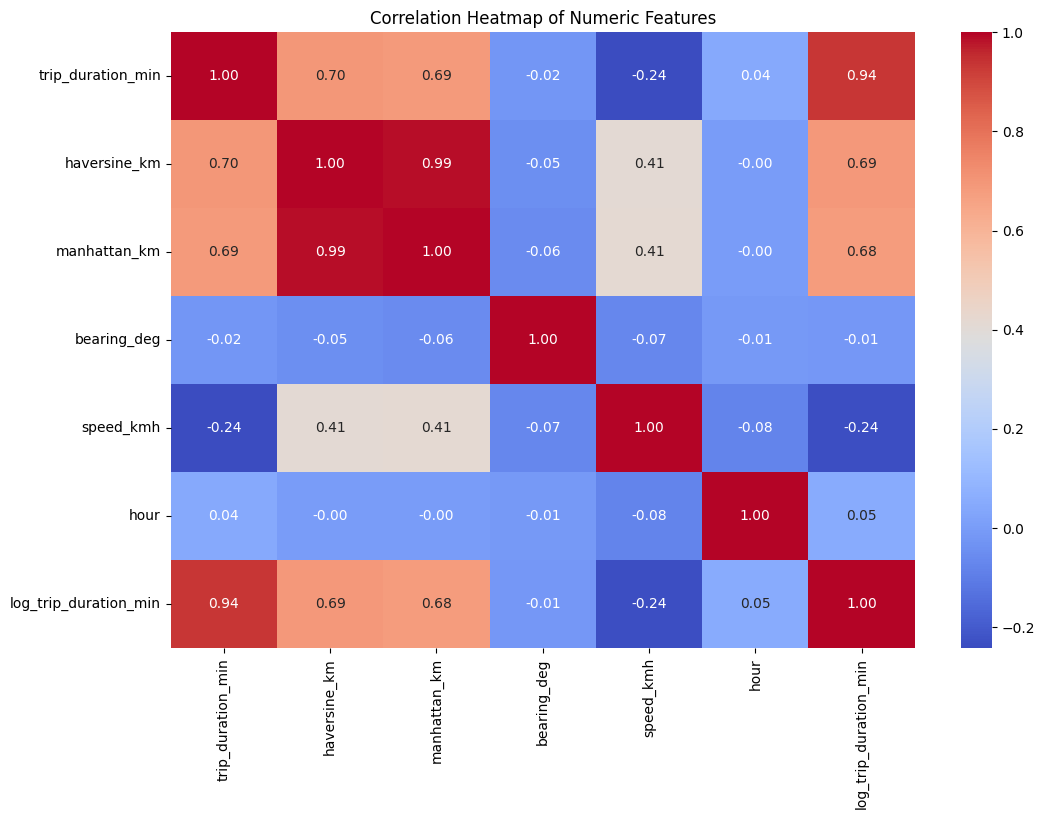

In [35]:
plt.figure(figsize=(12,8))
numeric_cols = ['trip_duration_min', 'haversine_km', 'manhattan_km', 'bearing_deg', 'speed_kmh', 'hour', 'log_trip_duration_min']
corr_matrix = df_processed[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


كده وضحلنا ان كل العلاقات منطقيه بينهم زي ان السرعه تتناسب عكسي مع مدة الرحله والمسافه طردي مع المده كل ما تزيد المسافه مدة الرحله تزيد 

وبكده مكون فهمنا كل حاجه وعدلنا عالداتا علي قدر المستطاع نبدا نخش فمرحلة الموديلينج